# Import Libraries

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # specify which GPU(s) to be used
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from utilities.m_net_factory import net_factory

from PIL import Image
import cv2
import albumentations as A
import numpy as np

import time

from tqdm.notebook import tqdm

from torchsummary import summary

# import seaborn as sns; sns.set_theme()
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#Similarity map
def sim_map(f_1):
    
    f_1 = f_1.view(f_1.size(0), -1)
    g_1  = torch.mm(f_1, f_1.t())
    norm_G_1 = F.normalize(g_1, p=2, dim=1)
    return g_1, norm_G_1

# Metrics

In [3]:
IMAGE_PATH_test = '.../data/NEU_data/test_images/'
MASK_PATH_test = '.../data/NEU_data/test_annot/'

n_classes = 4

def create_df_test():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH_test):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df_test = create_df_test()
print('Total Test Images: ', len(df_test))
X_test = df_test['id'].values


class NEUDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        
        return img, mask
    

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(p=0.4), A.VerticalFlip(p=0.4), 
                     A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.Blur(p = 0.3),
                     A.RandomRotate90(p=0.3),
                     A.GaussNoise(p = 0.3)])

t_val = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])
t_test = A.Compose([A.Resize(256, 256, interpolation=cv2.INTER_NEAREST)])

#datasets
test_set = NEUDataset(IMAGE_PATH_test, MASK_PATH_test, X_test, mean, std, t_val, patch=False)

#dataloader
batch_size= 24

test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 8, pin_memory = True,  shuffle=False)  


Total Test Images:  840


In [4]:
data = iter(test_loader)

inputs_S1, labels_S1 = next(data)
                
inputs, labels = inputs_S1.to(device), labels_S1.to(device)

In [5]:
model = net_factory(net_type='unet_f', in_chns=3, class_num=4)
# model = smp.Unet("resnet18", encoder_weights= None, classes=4, activation=None)

model = nn.DataParallel(model)


In [6]:
#Load model state dict

checkpoint_2 = torch.load("/.../model_weights/NEU_seg/simEps_10p_1.pth")

print(checkpoint_2['epoch'])
#Loading the trained model weight
model.load_state_dict(checkpoint_2['state_dict'])

print('The state dics are loaded')
# print(checkpoint_0['best_loss_1'])

427
The state dics are loaded


In [7]:
x4, _, _, _, f4, pred, _, _, _ = model(inputs)

In [8]:
print(x4.shape)
print(f4.shape)
print(pred.shape)

torch.Size([24, 256, 16, 16])
torch.Size([24, 16, 256, 256])
torch.Size([24, 4, 256, 256])


In [9]:
sim_1, sim_2= sim_map(f4)
im_1 = sim_2.to('cpu').detach().numpy()
#Normalizing the values to a range of [0,1]
outmap_min = np.min(im_1)
outmap_max = np.max(im_1)
outmap = (im_1 - outmap_min) / (outmap_max - outmap_min) # Broadcasting rules apply to normalize the outputs between  0 and 1

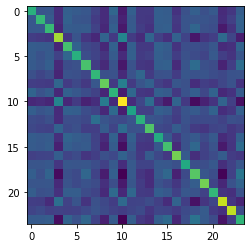

In [10]:
plt.imshow(outmap)
# plt.colorbar(im_1)
# plt.show()

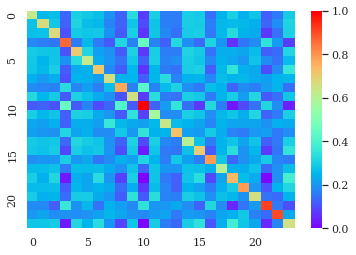

In [11]:
sns.set(font="serif")
# sns.set(Title="serif")

ax = sns.heatmap(outmap, cmap="rainbow", xticklabels=5, yticklabels=5)
# ax.set_title("Pairwise similarity map")